##seq2seq##

seq2seq은 encoder-decoder 구조로 이루어진 모델로 sequential data를 입력받고 출력하는 nlp의 여러 태스크에 사용될 수 있습니다.
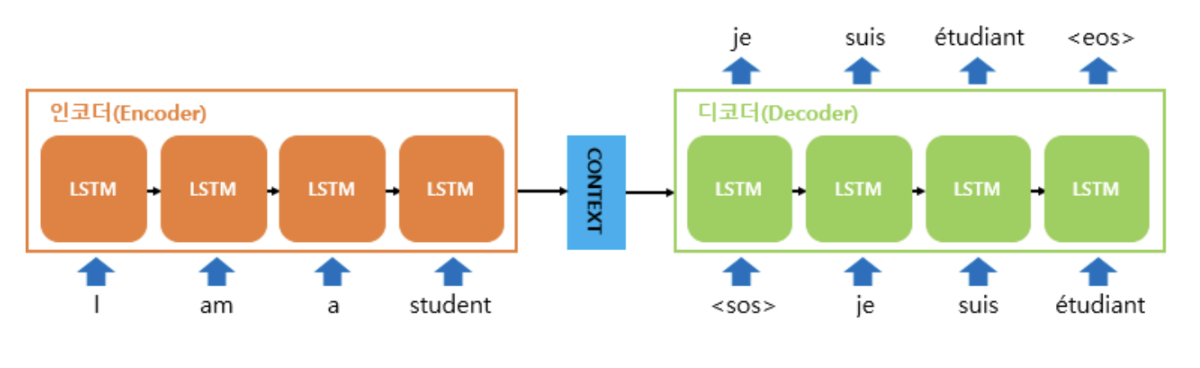

##Attention##

어텐션 기법은 Query, Key, Value를 기반으로 중요한 정보를 추출합니다.

어텐션은 현재 CV, NLP를 가리지 않고 여러 분야의 SOTA 모델에서 이용되는데,

dot product attention은 몇번의 행렬곱 연산으로 정의될 수 있어 연산 효율이 우수합니다.

seq2seq에 이용될 수 있는 attention을 행렬곱으로 정의해봅시다.

In [1]:
import torch
import torch.nn.functional as F

In [13]:
def Attention(Q, K, V):
  """
  Q : (hidden_size, 1) K : (hidden_size, num_key) V : (value_dim, num_key)
  """
  assert Q.shape[1] == K.shape[1], "Q, K vector size should match"
  assert K.shape[0] == V.shape[0], "K, V should have same number"

  ####################################   FILL HERE   #########################################
  #  1. Q와 K의 유사도는 내적으로 나타내집니다. attention score 벡터를 만듭니다. (num_key, 1)
  att_score = torch.dot(Q.transpose, K)
  #  2. 유사도 벡터에 softmax 연산을 가해 attention coefficient 벡터를 만듭니다. (num_key, 1)          #
  #     (hint) F.softmax()
  att_coef = F.softmax(att_score)                                                  #
  #  3. attention coefficient를 반영한 num_key개의 Value vector들의 평균을 찾습니다. (value_dim, 1)  #
  sum = att_coef * V
  att_mean = sum.mean()
  #  4. (value, )의 attentio_value로 만듭니다.                                                  #
  #     (hint) Tensor.squeeze()
  attention_value = att_mean.squeeze()                                                     #
  #                                                                  #
  ############################################################################################

  return attention_value

attention은 수번의 행렬곱으로 정의되므로 병렬 연산에 능하다는 장점이 있습니다. 그러나 seq2seq에 적용된 attention은 seq2seq의 순전파를 기다려야 해 연산의 장점을 얻을 수 없습니다. 그 다음에 등장한 트랜스포머는 attention만을 사용한 모델입니다.

##Data Pipeline##

이번 시간엔 seq2seq과 attention의 작동원리를 뜯어보기 위해 low-level의 seq2seq with attention을 구현했습니다.

보통 구현할 때는 이런 end-to-end의 구현을 하지 않습니다. huggingface, torchtext 등 dataset의 로딩과 전처리를 하나의 파이프라인으로 제공하는 인터페이스가 많이 있기 때문입니다.

예시로 torchtext의 기계번역 데이터셋을 전처리까지 포함하여 로딩하는 과정을 보여드리겠습니다.

In [ ]:
!apt install python3.7
!pip install -U torchtext==0.6.0
!python -m spacy download en
!python -m spacy download de

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.7 is already the newest version (3.7.17-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
2023-07-21 17:12:25.095499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 17:12:26.399149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-07-21 17:12:40.113786: I tensorflo

torchtext는 pytorch를 기반으로 nlp를 위한 여러 기능과 데이터셋을 제공하는 라이브러리입니다. torchtext는 간편한 전처리와 데이터 로딩, 데이터셋을 제공합니다.

In [ ]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import spacy

spacy의 토크나이저를 로딩해옵니다. 독일어와 영어 문장을 의미있는 단위로 끊어줄 것입니다.

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
[tok.text for tok in spacy_de.tokenizer("Hello! Today is my birthday.")]

['Hello', '!', 'Today', 'is', 'my', 'birthday', '.']

torchtext.Field는 편리하게 nlp 전처리를 할 수 있는 기능을 제공합니다. 아래에서는 문장을 의미있는 단위로 끊고 sos와 eos 토큰을 추가한 후 소문자로 교체하는 전처리를 지정합니다.

In [ ]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)][::-1] # reverse input

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

이제 필드를 지정하여 torchtext의 데이터셋을 불러올 수 있습니다. 독일어와 영어 데이터셋을 불러옵시다.

In [ ]:
train_data, val_data, test_data = Multi30k.splits(exts= ('.de', '.en'), fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 513kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 168kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 159kB/s]


29000개 정도의 train sample을 가지고 있습니다.

In [ ]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

29000
1014
1000


In [ ]:
print(vars(train_data[0])) # 인풋이 반전된 체로 잘 저장되었습니다.

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


데이터셋을 필드를 이용해 로딩한 후 단어집합을 정의할 수 있습니다. 단어 집합이 과하게 커질것을 방지해 단어 집합에 포함시키기 위한 최소 횟수, 단어 집합의 최대 크기를 지정할 수 있습니다.

In [ ]:
SRC.build_vocab(train_data, min_freq = 5, max_size=5000)
TRG.build_vocab(train_data, min_freq = 5, max_size=5000)

In [ ]:
print(len(SRC.vocab))
print(SRC.vocab.stoi) #stoi는 string-to-index라는 뜻으로 토큰과 인덱스의 대응 딕셔너리를 출력합니다.

3554
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7ff90afd2920>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, '.': 4, 'ein': 5, 'einem': 6, 'in': 7, 'eine': 8, ',': 9, 'und': 10, 'mit': 11, 'auf': 12, 'mann': 13, 'einer': 14, 'der': 15, 'frau': 16, 'die': 17, 'zwei': 18, 'einen': 19, 'im': 20, 'an': 21, 'von': 22, 'sich': 23, 'dem': 24, 'mädchen': 25, 'junge': 26, 'vor': 27, 'zu': 28, 'steht': 29, 'männer': 30, 'sitzt': 31, 'hund': 32, 'den': 33, 'straße': 34, 'während': 35, 'gruppe': 36, 'hält': 37, 'spielt': 38, 'das': 39, 'hemd': 40, 'personen': 41, 'über': 42, 'drei': 43, 'eines': 44, 'frauen': 45, 'blauen': 46, 'neben': 47, 'ist': 48, 'kind': 49, 'roten': 50, 'weißen': 51, 'stehen': 52, 'sitzen': 53, 'menschen': 54, 'am': 55, 'aus': 56, 'spielen': 57, 'durch': 58, 'bei': 59, 'geht': 60, 'trägt': 61, 'fährt': 62, 'wasser': 63, 'um': 64, 'kinder': 65, 'kleines': 66, 'person': 67, 'macht': 68, 'springt': 69, 'kleiner': 70, 'schwarzen':

In [ ]:
print(len(TRG.vocab))
print(SRC.vocab.stoi)

3270
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7ff90afd2920>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, '.': 4, 'ein': 5, 'einem': 6, 'in': 7, 'eine': 8, ',': 9, 'und': 10, 'mit': 11, 'auf': 12, 'mann': 13, 'einer': 14, 'der': 15, 'frau': 16, 'die': 17, 'zwei': 18, 'einen': 19, 'im': 20, 'an': 21, 'von': 22, 'sich': 23, 'dem': 24, 'mädchen': 25, 'junge': 26, 'vor': 27, 'zu': 28, 'steht': 29, 'männer': 30, 'sitzt': 31, 'hund': 32, 'den': 33, 'straße': 34, 'während': 35, 'gruppe': 36, 'hält': 37, 'spielt': 38, 'das': 39, 'hemd': 40, 'personen': 41, 'über': 42, 'drei': 43, 'eines': 44, 'frauen': 45, 'blauen': 46, 'neben': 47, 'ist': 48, 'kind': 49, 'roten': 50, 'weißen': 51, 'stehen': 52, 'sitzen': 53, 'menschen': 54, 'am': 55, 'aus': 56, 'spielen': 57, 'durch': 58, 'bei': 59, 'geht': 60, 'trägt': 61, 'fährt': 62, 'wasser': 63, 'um': 64, 'kinder': 65, 'kleines': 66, 'person': 67, 'macht': 68, 'springt': 69, 'kleiner': 70, 'schwarzen':

이외에 데이터셋을 순회하는 Iterator class, 사전학습된 tokenizer 등도 지원합니다. 자세한 내용은 torchtext 공식문서를 참고해주세요.

##Dataset & DataLoader##

pytorch에서 데이터 셋을 구축하고 파이프라인을 만드는 것은 대부분 torch.utils.data.Dataset 과 torch.utils.data.DataLoader로 이루어집니다.

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#loading-a-dataset

위 튜토리얼을 참고해 다음 질문에 답해주세요

#Q1#

Dataset 클래스를 상속받아서 나만의 데이터셋을 정의할 수 있습니다. 이때 dataset 클래스가 구현해야 하는 3가지 메서드는 무엇인가요?


In [ ]:
__init__, __len__, __getitem__

Q2

DataLoader는 Dataset객체를 받아 일정한 batch 크기(batch_size) 단위로 접근할 수 있도록 iterator를 반환합니다. 데이터 셋을 일정한 크기의 배치로 쪼개어 사용하는 이용하는 이유는 무엇인가요?

In [ ]:
매 에폭마다 데이터를 다시 섞어서 과적합을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이기 위함입니다.